# Transfer Learning Project 


> Using Googlenet Pretrained Model

> 2021-1 Semeter MLclass

>  201627044 윤영민



In [ ]:
# 학습에 필요한 패키지 import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np
import time
import copy

# Data Loader And Print Samples

In [ ]:
# 불러온 데이터를 학습을 위해 정규화해줍니다
data_transforms = {
    # trainset 변경
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # testset 변경
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Transfer Learning을 위한 New dataset을 Load 하는 코드
# 데이터셋은 라이브러리에서 불러올수 있어서 간단하게 사용가능하고, 데이터 sample수도 많아서 좋을 것이라고 생각해 CIFAR10을 사용했습니다.
# CIFAR10 dataset의 trainset을 불러온다. batch_size = 64, shuffle = True
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train'])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)

# CIFAR10 dataset의 testset을 불러온다. batch_size = 64, shuffle = True
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['test'])  
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=4)

# 분류할 class이름들을 train_set에서 가져옵니다.
class_names = train_set.classes

# dataloaders와 dataset_sizes 변수를 각각 train 과 test 라는 key를 갖는 dictionary로 선언해줍니다.
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_set), 'test': len(test_set)}            

# 계산에 gpu를 사용하나 안될 경우 cpu 사용, code구현하는동안 colab gpu가 자주 이용불가가 돼서 오래걸렸습니다....
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


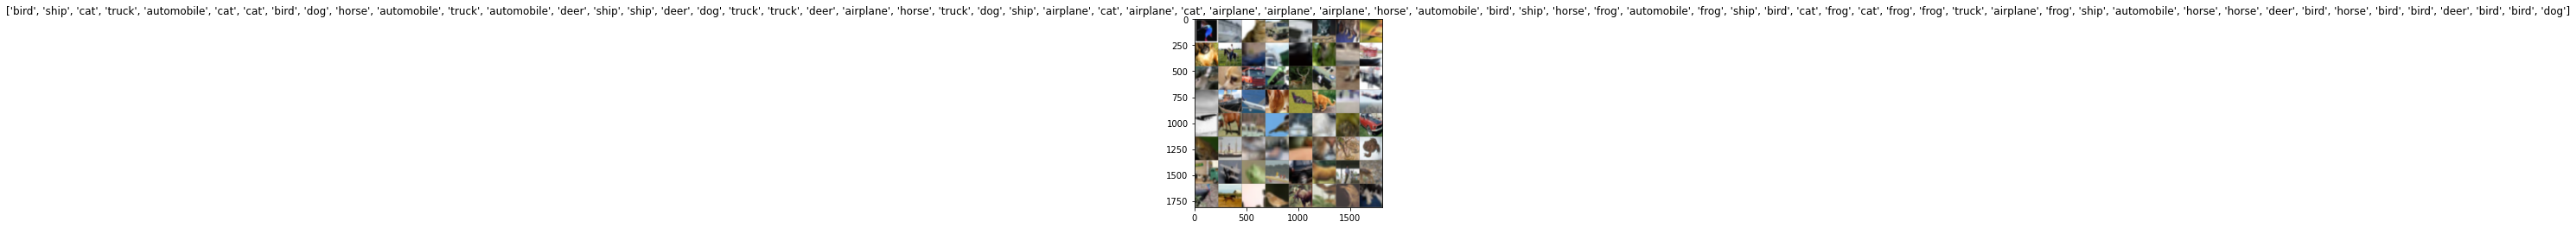

In [ ]:
# dataset에서 불러온 이미지를 batch_size의 수에 맞게 출력해주는 함수
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# train data에 batch를 가져옵니다
inputs, classes = next(iter(dataloaders['train']))

# batch로부터 grid를 만듭니다.
out = torchvision.utils.make_grid(inputs)

# 위에서 만들어준 imshow함수를 사용해 이미지를 출력해줍니다.
imshow(out, title=[class_names[x] for x in classes])

# Function for Pretrained Model Visualized Model

In [ ]:
# pretrained model을 가지고 학습하는 함수
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)

        # 각각의 epoch은 train과 test의 경우를 가집니다
        for phase in ['train', 'test']:
            if phase == 'train':
                # 'train'인 경우, pretrained model을 training mode로 설정
                model.train()
            else:
                 # 'test'인 경우, pretrained model을 evaluate mode로 설정
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # data들을 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward propagation 수행
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 'train'인 경우 backward propagaion + optimize 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 각 수치들을 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            # train과 test인 경우에 대해 각각 epoch에 해당하는 손실(loss)과 정확도(accuracy)를 계산한다.
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # 손실과 정확도 출력
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # 수행시간이 얼마나 걸렸는지 출력
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # best model weight를 load한다.
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# test_dataset으로 예측 결과를 10장 출력
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # 예측 결과의 출력
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Googlenet Pretrained Model**(None used extractor)

In [ ]:
# ConvNet as fixed feature extractor 사용한 모델의 정확도가 너무 낮아서
#사용한 모델과 사용하지 않은 모델을 비교하기 위해 같은 googlenet을 두가지로 나눴습니다.
# pretrained googlenet의 convnet을 고정한 모델과 고정하않은 모델의 비교를 위해 모든 convnet을 optimize하도록 수정하였습니다.
# finetuning the convnet 사용
# pretrained Googlenet 사용을 위한 설정

# pre-trained model을 Load하는 코드
googlenet = models.googlenet(pretrained=True)

# 3. pre-trained model을 Transfer Learning 하는 코드 (모델 전체를 Fine-Tuning하는 코드)
# pretrained googlenet의 마지막 layer의 output의 수 10개로 수정
num_features = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_features,10)
googlenet = googlenet.to(device)

# CrossEntropy 사용
criterion = nn.CrossEntropyLoss()

# pretrained googlenet의 모든 parameter가 optimize 되도록 한다.
optimizer_gn = optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)

# epoch이 1번 돌 때 마다 0.1씩 LR을 줄인다.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_gn, step_size=5, gamma=0.1)

In [ ]:
# Transfer Learning이 끝난 후, New dataset에 대한 성능을 예측하는 코드
model_gn = train_model(googlenet, criterion, optimizer_gn, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.2172 Acc: 0.5953
test Loss: 0.4110 Acc: 0.8695

Epoch 1/9
--------------------
train Loss: 0.7315 Acc: 0.7461
test Loss: 0.2930 Acc: 0.9035

Epoch 2/9
--------------------
train Loss: 0.6315 Acc: 0.7814
test Loss: 0.2450 Acc: 0.9154

Epoch 3/9
--------------------
train Loss: 0.5886 Acc: 0.7971
test Loss: 0.2162 Acc: 0.9282

Epoch 4/9
--------------------
train Loss: 0.5520 Acc: 0.8098
test Loss: 0.2087 Acc: 0.9258

Epoch 5/9
--------------------
train Loss: 0.5193 Acc: 0.8205
test Loss: 0.1928 Acc: 0.9338

Epoch 6/9
--------------------
train Loss: 0.5005 Acc: 0.8277
test Loss: 0.1868 Acc: 0.9351

Epoch 7/9
--------------------
train Loss: 0.5004 Acc: 0.8273
test Loss: 0.1809 Acc: 0.9367

Epoch 8/9
--------------------
train Loss: 0.5004 Acc: 0.8279
test Loss: 0.1812 Acc: 0.9376

Epoch 9/9
--------------------
train Loss: 0.4971 Acc: 0.8286
test Loss: 0.1791 Acc: 0.9356

Training complete in 77m 20s
Best test Acc: 0.937600


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


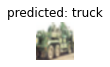

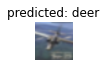

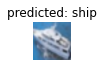

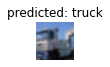

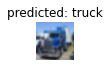

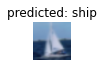

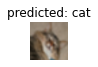

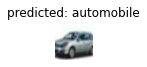

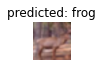

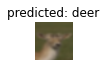

In [ ]:
visualize_model(model_gn)

In [ ]:
# Save model 학습한 모델 저장
torch.save(model_gn.state_dict(), "model.pth")

# Load model 학습한 모델 불러오기
model_gn.load_state_dict(torch.load("model.pth")) 

# **Googlenet Pretrained Model**(Covnet as fixed feature extractor)

In [ ]:
# dataset을 CIFAR10으로 선택한 후 분류 문제에 사용되는 모델을 찾았습니다.
# pretrained model로는 2014 이미지넷 사진 인식 대회에서 1등을 수상한 Googlenet을 선택했습니다
# 1. New dataset is small and simillar to original dataset

# Code for pre-trained model Loading
#googlenet = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=True)
# torchvision의 models에서 googlenet이 구현되어있는 함수를 사용했습니다.

googlenet_ft = models.googlenet(pretrained=True)

#print(googlenet) #googlenet의 전체적인 구조를 이해하기 위해 구조를 출력
# Code for pre-trained model to Transfer Learning
#모든 파라미터 모델 고정
#pretrained googlenet의 모든 convnet을 고정하고 fc layer의 마지막 부분의 prameters만 수정하고자 하였습니다. 
# ConvNet as fixed feature extractor 사용
for param in googlenet_ft.parameters():
     param.required_grad = False

# # pretrained googlenet의 마지막 layer의 output의 수 10개로 수정
num_features = googlenet_ft.fc.in_features

##fc를 새로 num_features와 클래스갯수 10개로 수정
googlenet_ft.fc = nn.Linear(num_features,10)
##device로 보내서 연산
googlenet_ft = googlenet_ft.to(device)

# # CrossEntropy 사용
criterion = nn.CrossEntropyLoss()

# # pretrained googlenet의 마지막 fc에서의 parameter가 optimize 되도록 한다.
optimizer_ft = optim.SGD(googlenet_ft.fc.parameters(), lr=0.001, momentum=0.9)

# # epoch이 1번 돌 때 마다 0.1씩 LR을 줄인다.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [ ]:
# Transfer Learning이 끝난 후, New dataset에 대한 성능을 예측하는 코드
model_gn_ft = train_model(googlenet_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.7470 Acc: 0.4463
test Loss: 1.2195 Acc: 0.6630

Epoch 1/9
--------------------
train Loss: 1.3992 Acc: 0.5389
test Loss: 1.0448 Acc: 0.6820

Epoch 2/9
--------------------
train Loss: 1.3150 Acc: 0.5555
test Loss: 0.9752 Acc: 0.6953

Epoch 3/9
--------------------
train Loss: 1.2809 Acc: 0.5625
test Loss: 0.9234 Acc: 0.7128

Epoch 4/9
--------------------
train Loss: 1.2626 Acc: 0.5662
test Loss: 0.9058 Acc: 0.7092

Epoch 5/9
--------------------
train Loss: 1.2456 Acc: 0.5683
test Loss: 0.8884 Acc: 0.7177

Epoch 6/9
--------------------
train Loss: 1.2463 Acc: 0.5715
test Loss: 0.8824 Acc: 0.7172

Epoch 7/9
--------------------
train Loss: 1.2442 Acc: 0.5736
test Loss: 0.8862 Acc: 0.7162

Epoch 8/9
--------------------
train Loss: 1.2407 Acc: 0.5729
test Loss: 0.8801 Acc: 0.7223

Epoch 9/9
--------------------
train Loss: 1.2389 Acc: 0.5705
test Loss: 0.8883 Acc: 0.7162

Training complete in 76m 34s
Best test Acc: 0.722300


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


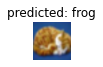

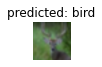

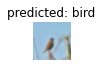

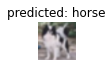

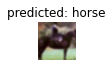

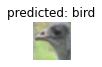

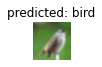

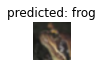

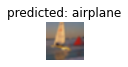

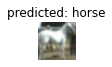

In [ ]:
visualize_model(model_gn_ft)

In [ ]:
# Save model 학습한 모델 저장
torch.save(model_gn.state_dict(), "model.pth")

# Load model 학습한 모델 불러오기
model_gn.load_state_dict(torch.load("model.pth")) 